
# Project: Analysis of Brazil's Medical Appointment 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The following report is based on the No-show appointment dataset obtained from Kaggle. This dataset is about patients in brazil who scheduled an appointment and did or did not show up. So they have collected more details about each patient like their gender , age and the diseases they have. With the data collected I am going to analysis to see if there is a relation between the variables collected. 

The dataset consists of the PatientID, AppointmentID, Gender, ScheduledDay, AppointmentDay, Age, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received, No-show. For my analysis No-show is dependent variable and gender, age and alcoholism are the three independent variable.

Question 1: Whose is most likely to miss their appointment men or women ?

Question 2: Which age group Alcoholic's are more likely to miss their appointment?



In [278]:
# Installing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

% matplotlib inline
sns.set_style("whitegrid")

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [250]:
# Reading the dataset to variable df using pandas 
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [251]:
df.shape
df.info() # The scheduledDay and AppointmentDay are objects instead of date and time. 
df.isnull().any();  # There are no missing values
df.describe(); # age column consists of -1 (needs to removed)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB



### Data Cleaning 

The dataset consists of 14 columns and 110527 entries with no null values. The Columns names are mixed with lowercase and 
uppercase and need to changed to a more convenient format for our ease. ScheduledDay and AppointmentDay columns are object 
datatype instead of date and time type, the other columns have the right data type. 
    There are some columns like PatientId, AppointmentID are not required for us so they can be dropped. To reduce the memory
gender and No-show column are converted to Categorical datatype. Need to check for duplicates and have to remove them.

In [252]:
# Columns patientid and appointment id are not useful for the analysis so they are being dropped
df.drop(['PatientId','AppointmentID'], axis = 1, inplace = True)

In [253]:
# Changing the column name to lower case
df.rename(columns = str.lower, inplace= True)
df.rename(columns={'appointmentday': 'appointment_day', 'scheduledday': 'scheduled_day', 'hipertension':'hypertension',
                   'no-show':'no_show', 'handcap':'handicap'}, inplace=True)

In [254]:
#checking for duplicates
df[df.duplicated()]

# I have dropped all duplicates
df.drop_duplicates(inplace = True)

In [255]:
# Converted the columns to date and time format. 
df.scheduled_day =  pd.to_datetime(df.scheduled_day)
df.appointment_day =  pd.to_datetime(df.appointment_day)
df['waiting_time'] = abs(df.appointment_day - df.scheduled_day)

In [256]:
# Changed to Categorical level since there are just two outputs
df.gender = pd.Categorical(df.gender)
df.no_show = pd.Categorical(df.no_show)

In [257]:
# Removing rows with age less than 0.
df = df[df.age >= 0]

#Renaming No-show column
df["no_show"] = df["no_show"].map({"Yes": 1, "No": 0})
df["gender"] = df["gender"].map({"F": 0, "M": 1})

In [258]:
df.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_time
0,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,18:38:08
1,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,16:08:27
2,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,16:19:04
3,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,17:29:31
4,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,16:07:23


# Data Distribution

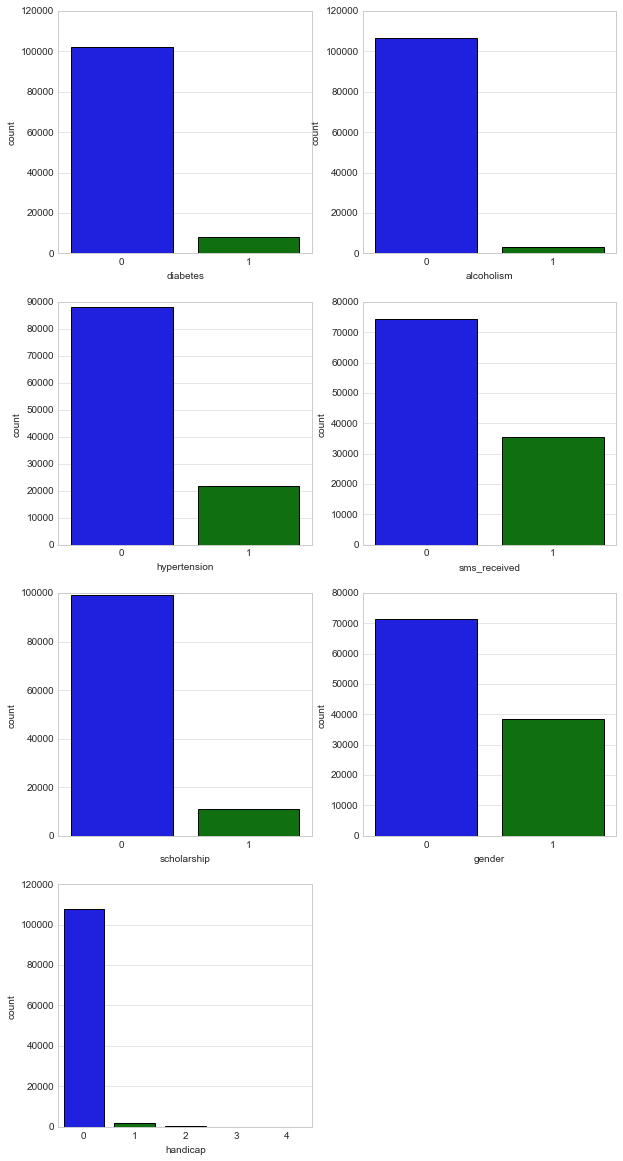

In [259]:
features = ["diabetes","alcoholism","hypertension","sms_received","scholarship","gender", "handicap"]

plt.figure(figsize=(10,20))
gs = gridspec.GridSpec(4, 2)

for i,feature in enumerate(features):
    ax = plt.subplot(gs[(i // 2),(i % 2)])
    sns.countplot(df[feature], ax = ax)

plt.show()

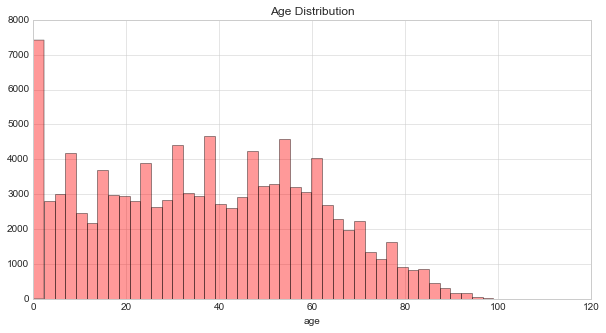

In [260]:
#Age distribution
plt.figure(figsize=(10, 5))
sns.distplot(df.age, kde=False, color = 'red')
plt.title("Age Distribution")
plt.show()

In [261]:
df.sample(5)

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_time
23618,0,2016-04-05 08:23:12,2016-05-11,89,DO QUADRO,0,1,0,0,0,0,1,35 days 15:36:48
46076,0,2016-05-04 16:36:38,2016-05-04,48,MARUÍPE,0,0,0,0,0,0,0,0 days 16:36:38
27289,0,2016-04-29 08:22:16,2016-05-12,51,JOANA D´ARC,0,0,0,0,0,1,1,12 days 15:37:44
19803,0,2016-04-14 13:29:47,2016-05-03,27,BELA VISTA,0,0,0,0,0,1,0,18 days 10:30:13
14834,0,2016-05-17 10:31:07,2016-05-19,1,SANTA TEREZA,0,0,0,0,0,0,0,1 days 13:28:53


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 : Whose is most likely to miss their appointment men or women ?

In [262]:
# Finding out the Percentage of women attending and not attending the Appointment
# total number of women
women = df.query('gender =="F"').gender.count() 

# Women who showed up for the appointment
women_in = df.query('gender =="F" and no_show == False').gender.count()

# Women who didnt show up for the appointment
women_out = df.query('gender =="F" and no_show == True').gender.count()

# Dividing women who showed and didnt show up by total women.
per_women_in, per_women_out = women_in / women, women_out / women

print('The percentage of women who attended their appointment is {}% and the percentage of women who missed their appointment is \n {}%'
      .format(round(per_women_in * 100, 2), round(per_women_out * 100, 2)))

The percentage of women who attended their appointment is nan% and the percentage of women who missed their appointment is 
 nan%


In [263]:
# Finding the Percentage of men now
#Total number of men
men = df.query('gender == "M"').gender.count()

# Men who showed up 
men_No = df.query('gender =="M" and no_show == False').gender.count()

# Men who didnt show up
men_Yes = df.query('gender =="M" and no_show == True').gender.count()

# Percentage of men who showed up and didnt show up
per_men_in,per_men_out = men_No / men , men_Yes / men

print('The percentage of men who attended their appointment is {}% and the percentage of men who missed their appointment is {}%'
      .format(round(per_men_in * 100, 2), round(per_men_out * 100, 2)))

The percentage of men who attended their appointment is nan% and the percentage of men who missed their appointment is nan%


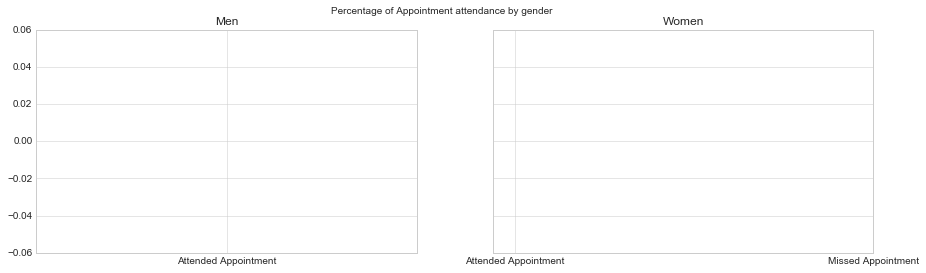

In [264]:
# Plotting the Percentage of men and women attending / missing appointment 

x = np.arange(2)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey = True,figsize = (15,4))
ax1.bar(x,[per_men_in,per_men_out],color='red')
ax2.bar(x,[per_women_in,per_women_out])
ax1.set_title('Men')
ax2.set_title('Women')
fig.suptitle('Percentage of Appointment attendance by gender')
plt.xticks(x,('Attended Appointment', 'Missed Appointment'))
plt.show()

 ## Obersavtion
 
The percentage of women attending their appointment is 79.76% and the percentage of women missing their appointment is 20.24% and the percentage of men attending their appointment is 80.14% and the percentage of men missing their appointment is 19.86%.
So the chances of a women missing an appointment is slightly more than men.
 

### Research Question 2: Which age group Alcoholic's are more likely to miss their appointment?

People of all age drink and some are addicted at a very young age. So I wanted investigate if any particular age group is more 
likely to miss their appointment if they are alcoholics.

In [265]:
# Children who are alcoholic and showed up 
No_child = df.query('alcoholism == 1 and age <= 18 and age >= 0 and no_show == False').gender.count()

# Children who are alcoholic and didnt showed up 
Yes_child = df.query('alcoholism == 1 and age <= 18 and age >= 0 and no_show == True').gender.count()

# Total number of children who are alcoholic
child = No_child + Yes_child

# Percentage of children who showed up and didnt showed up
Per_No_child, Per_Yes_child =  No_child / child, Yes_child / child

print('The percentage of Children who attended their appointment is {}% and percentage of Children who missed their appointment is {}%'
      .format(round(Per_No_child * 100, 2), round(Per_Yes_child * 100, 2)))

The percentage of Children who attended their appointment is 57.14% and percentage of Children who missed their appointment is 42.86%


In [266]:
# young adults who are alcoholic and showed up 
No_young = df.query('alcoholism == 1 and age <= 36 and age > 18 and no_show == False').gender.count()

# young adults who are alcoholic and didnt showed up 
Yes_young = df.query('alcoholism == 1 and age <= 36 and age > 18 and no_show == True').gender.count()

# Total young adults who are alcoholics 
young = No_young + Yes_young

# Percentage of young adults who showed up and didnt showed up
Per_No_young, Per_Yes_young =  No_young / young, Yes_young / young

print('The percentage of young adults who attended their appointment is {} % and percentage of young adults who missed their \n appointment is {}%'
      .format(round(Per_No_young * 100, 2), round(Per_Yes_young * 100, 2)))

The percentage of young adults who attended their appointment is 73.65 % and percentage of young adults who missed their 
 appointment is 26.35%


In [267]:
# young adults who are alcoholic and showed up 
No_adults = df.query('alcoholism == 1 and age <= 60 and age > 36 and no_show == "No"').gender.count()

# young adults who are alcoholic and didnt showed up 
Yes_adults = df.query('alcoholism == 1 and age <= 60 and age > 36 and no_show == "Yes"').gender.count()

# Total adults who are alcoholics 
adults = No_adults + Yes_adults

# Percentage of adults who showed up and didnt showed up
Per_No_adults, Per_Yes_adults =  No_adults / adults, Yes_adults / adults

print('The percentage of adults who attended their appointment is {} % and percentage of adults who missed their appointment is \n {}%'
      .format(round(Per_No_adults * 100, 2), round(Per_Yes_adults * 100, 2)))

The percentage of adults who attended their appointment is nan % and percentage of adults who missed their appointment is 
 nan%


In [268]:
# old adults who are alcoholic and didnt showed up 
No_old = df.query('alcoholism == 1 and age > 60 and no_show == "No"').gender.count()

# old adults who are alcoholic and didnt showed up 
Yes_old = df.query('alcoholism == 1 and age > 60 and no_show == "Yes"').gender.count()


# Total  old adults who are alcoholics 
old = No_old + Yes_old

# Percentage of old adults who showed up and didnt showed up
Per_No_old, Per_Yes_old =  No_old / old, Yes_old / old

print('The percentage of old adults who attended their appointment is {} % and percentage of old adults who missed their appointment is {}%'
      .format(round(Per_No_old * 100, 2), round(Per_Yes_old * 100, 2)))

The percentage of old adults who attended their appointment is nan % and percentage of old adults who missed their appointment is nan%


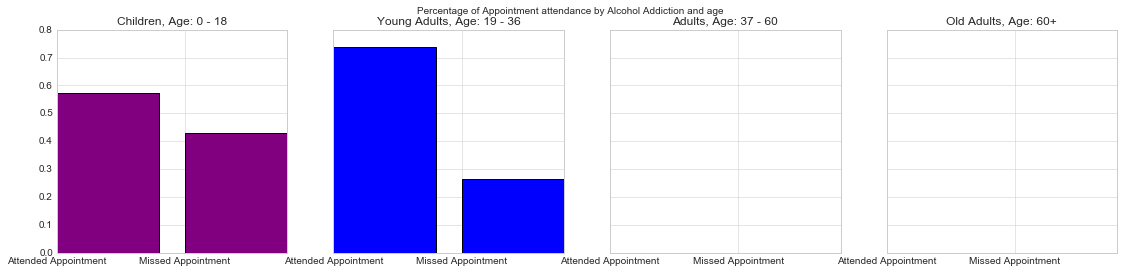

In [269]:
# Plotting the alcholics divided into age group who attending / missing appointment 
x = np.arange(2)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey = True,figsize = (19,4))

ax1.bar(x,[Per_No_child,Per_Yes_child],color = 'Purple')
ax2.bar(x,[Per_No_young,Per_Yes_young])
ax3.bar(x,[Per_No_adults,Per_Yes_adults],color = 'palegreen')
ax4.bar(x,[Per_No_old, Per_Yes_old],color = 'navy')

ax1.set_title('Children, Age: 0 - 18')
ax2.set_title('Young Adults, Age: 19 - 36')
ax3.set_title('Adults, Age: 37 - 60')
ax4.set_title('Old Adults, Age: 60+')
fig.suptitle('Percentage of Appointment attendance by Alcohol Addiction and age')
plt.xticks(x,('Attended Appointment', 'Missed Appointment'))
plt.show()

# Predictation

In [270]:
# Reshaping the data 
X = df[features].values
y = df['no_show'].values.reshape(-1, 1)

# Splitting the data into training and test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

# Standardizing the data 
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [271]:
# Logistic Regression Model 
logistic = LogisticRegression()
y_pred = logistic.fit(x_train,y_train).predict(x_test)

print('The accuracy is : {}'.format(round(accuracy_score(y_pred, y_test)* 100,2)))

The accuracy is : 80.02


In [272]:
# Decision Tree Model
decision_tree = DecisionTreeClassifier(criterion='gini')
y_pred = decision_tree.fit(x_train,y_train).predict(x_test)

print('The accuracy is : {}'.format(round(accuracy_score(y_pred, y_test)* 100,2)))

The accuracy is : 80.04


In [280]:
svc = SVC(kernel = 'rbf', gamma=.03, C=1.0)
y_pred = svc.fit(x_train, y_train).predict(x_test)

print('The accuracy is : {}'.format(round(accuracy_score(y_pred, y_test)* 100,2)))

The accuracy is : 80.02


<a id='conclusions'></a>
## Conclusions


After analyzing the dataset based on my research questions, I conclude the following

#### Question 1: Whose is most likely to miss their appointment men or women ?
I found women (20.24%) are slightly more likely to miss their appointments compared to men (19.86%). I have not applied any statsical tests on the dataset. Analysis was done though the ratio of men and women weren't equal. 

I can't give any suggestions to improve no-show rates because the information gathered doesn't provide the time of the appointment and women might not perfer to attend the appointments later in the day. As 62.70% of all attacks on women take place during the later part of the day. Source - https://www.libraryindex.com/pages/447/Victims-Crime-WHEN-WHERE-DOES-VIOLENT-CRIME-HAPPEN.html . Brazil has got a high crime rate, therefore this information may or may not provide the reason for it. 

The limitation is the dataset doesnt provide the time of the appointment. Which could help us understand if thats the reason for women missing appointments.

#### Question 2: Which age group Alcoholic's are more likely to miss their appointment?
For this analysis, the dataset was divided into four groups according to their age. Only people who are alcoholic were considered. It is evident that children (age: 0-18) are more likely to miss their appointment (42%) than any other age group. The old adults (age: 60+) are least likely to miss their appointment (13%). The percentage of alcholics who missed their appointment is decreasing as grow go older.  

The limitation is dataset provided, the number of children who are alcoholic was very less when compared to the other age group. 
The dataset doesnt contain enough data for alcoholics under 18 to be compared with the other age groups.

#### Note:
Used kaggle to read about the data.